In [303]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
scaler=MinMaxScaler()
df=pd.read_csv("daily")
temp_df=df.copy(deep=True)
temp_df["season"].replace({"Winter":0,"Spring":1,"Summer":2,
                        "Autumn":3}, inplace=True)
temp_df["weekday"].replace({"Sun":0,"Mon":1,"Tue":2,"Wed":3,"Thu":4,
                                "Fri":5,"Sat":6}, inplace=True)
temp_df["weather"].replace({"good":0,"cloudy":1,"overcast":2,"rain":3,
                                "snow":4}, inplace=True)
a=["instant", "date", "casual", "registered", "day"]
temp_df.drop(a, axis=1, inplace=True)
scores=[]

Normally we would check our data for missing/junk values, duplicates etc, but since we have worked extensively with this particular dataset, we know it is good.

In [304]:
temp_df["season"]=temp_df["season"].astype("category")
temp_df["weather"]=temp_df["weather"].astype("category")
temp_df["month"]=temp_df["month"].astype("category")
temp_df["weekday"]=temp_df["weekday"].astype("category")
temp_df["year"]=temp_df["year"].astype("category")

In [305]:
temp_df=pd.get_dummies(temp_df, drop_first=True)
np.random.seed(0)
dftrain, dftest= train_test_split(temp_df, train_size=0.7,
                                    test_size=0.3, random_state=100)
a=["temp", "ftemp", "hum", "windspeed", "cnt"]
dftrain[a]=scaler.fit_transform(dftrain[a])
ytrain=dftrain["cnt"]
xtrain=dftrain.drop("cnt", axis=1)

In [306]:
reg=LinearRegression()
reg.fit(xtrain, ytrain)
rfe=RFE(reg, n_features_to_select=15)
rfe=rfe.fit(xtrain, ytrain)
list(zip(xtrain.columns, rfe.support_, rfe.ranking_))
a=xtrain.columns[rfe.support_]
xtrain_rfe=xtrain[a]

In [307]:
vif=pd.DataFrame()
vif["features"]=xtrain_rfe.columns
vif["vif"]=[variance_inflation_factor(xtrain_rfe.values, i)
            for i in range(xtrain_rfe.shape[1])]
vif["vif"]=round(vif["vif"], 2)
vif=vif.sort_values(by="vif", ascending=False)
xtrain_lr1=sm.add_constant(xtrain_rfe)
lr1=sm.OLS(ytrain, xtrain_lr1).fit()
vif

,features,vif
6,month_6,inf
7,month_7,inf
8,month_8,inf
13,season_2,inf
0,temp,1768.33
1,ftemp,1650.92
2,hum,8.85
14,season_3,5.11
12,season_1,4.33
3,windspeed,4.18


In [308]:
print(lr1.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     176.0
Date:                Tue, 12 Jul 2022   Prob (F-statistic):          4.89e-182
Time:                        14:26:02   Log-Likelihood:                 493.26
No. Observations:                 511   AIC:                            -956.5
Df Residuals:                     496   BIC:                            -893.0
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2877      0.022     13.006      0.0

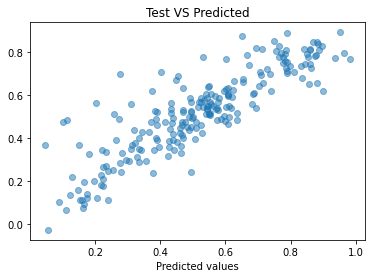

In [309]:
a=["temp", "ftemp", "hum", "windspeed", "cnt"]
temp=dftest.copy(deep=True)
temp[a]=scaler.transform(temp[a])
ytest=temp["cnt"]
xtest=temp.drop("cnt", axis=1)
a=xtrain_rfe.columns
xtest=xtest[a]
xtest_lr1=sm.add_constant(xtest)
ypred=lr1.predict(xtest_lr1)
plt.scatter(ytest, ypred, alpha=0.5)
plt.title("Test VS Predicted")
plt.xlabel("Test values")
plt.xlabel("Predicted values")
plt.show()
scores.append(r2_score(ytest, ypred))

In [310]:
xtrain_new=xtrain_rfe.drop(["season_2"], axis=1)
vif=pd.DataFrame()
vif["features"]=xtrain_new.columns
vif["vif"]=[variance_inflation_factor(xtrain_new.values, i)
            for i in range(xtrain_new.shape[1])]
vif["vif"]=round(vif["vif"], 2)
vif=vif.sort_values(by="vif", ascending=False)
xtrain_lr2=sm.add_constant(xtrain_new)
lr2=sm.OLS(ytrain, xtrain_lr2).fit()
vif

,features,vif
0,temp,1768.33
1,ftemp,1650.92
2,hum,8.85
8,month_8,5.41
7,month_7,5.25
13,season_3,5.11
12,season_1,4.33
3,windspeed,4.18
6,month_6,4.17
9,month_9,2.81


In [311]:
print(lr2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     176.0
Date:                Tue, 12 Jul 2022   Prob (F-statistic):          4.89e-182
Time:                        14:26:03   Log-Likelihood:                 493.26
No. Observations:                 511   AIC:                            -956.5
Df Residuals:                     496   BIC:                            -893.0
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2877      0.022     13.006      0.0

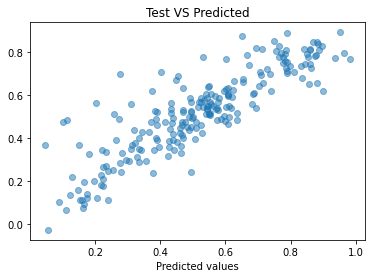

In [312]:
a=["temp", "ftemp", "hum", "windspeed", "cnt"]
temp=dftest.copy(deep=True)
temp[a]=scaler.transform(temp[a])
ytest=temp.pop("cnt")
xtest=temp
a=xtrain_new.columns
xtest=xtest[a]
xtest_lr2=sm.add_constant(xtest)
ypred=lr2.predict(xtest_lr2)
fig=plt.figure()
a=plt.scatter(ytest, ypred, alpha=0.5)
plt.title("Test VS Predicted")
plt.xlabel("Test values")
plt.xlabel("Predicted values")
plt.show()
scores.append(r2_score(ytest, ypred))

In [313]:
xtrain_new=xtrain_rfe.drop(["season_2", "ftemp"], axis=1)
vif=pd.DataFrame()
vif["features"]=xtrain_new.columns
vif["vif"]=[variance_inflation_factor(xtrain_new.values, i)
            for i in range(xtrain_new.shape[1])]
vif["vif"]=round(vif["vif"], 2)
vif=vif.sort_values(by="vif", ascending=False)
xtrain_lr3=sm.add_constant(xtrain_new)
lr3=sm.OLS(ytrain, xtrain_lr3).fit()
vif

,features,vif
0,temp,34.35
1,hum,8.41
12,season_3,5.10
6,month_7,4.96
7,month_8,4.94
11,season_1,4.32
5,month_6,3.85
2,windspeed,3.50
8,month_9,2.57
9,month_10,2.10


In [314]:
print(lr3.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     189.8
Date:                Tue, 12 Jul 2022   Prob (F-statistic):          3.89e-183
Time:                        14:26:04   Log-Likelihood:                 493.15
No. Observations:                 511   AIC:                            -958.3
Df Residuals:                     497   BIC:                            -899.0
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2881      0.022     13.038      0.0

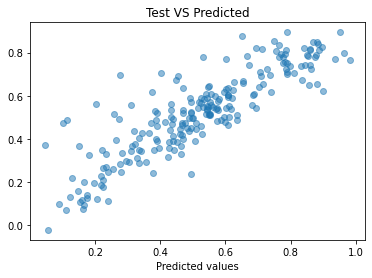

In [315]:
a=["temp", "ftemp", "hum", "windspeed", "cnt"]
temp=dftest.copy(deep=True)
temp[a]=scaler.transform(temp[a])
ytest=temp.pop("cnt")
xtest=temp
a=xtrain_new.columns
xtest=xtest[a]
xtest_lr3=sm.add_constant(xtest)
ypred=lr3.predict(xtest_lr3)
fig=plt.figure()
plt.scatter(ytest, ypred, alpha=0.5)
plt.title("Test VS Predicted")
plt.xlabel("Test values")
plt.xlabel("Predicted values")
plt.show()
scores.append(r2_score(ytest, ypred))

In [316]:
xtrain_new=xtrain_rfe.drop(["season_2", "ftemp", "hum"], axis=1)
vif=pd.DataFrame()
vif["features"]=xtrain_new.columns
vif["vif"]=[variance_inflation_factor(xtrain_new.values, i)
            for i in range(xtrain_new.shape[1])]
vif["vif"]=round(vif["vif"], 2)
vif=vif.sort_values(by="vif", ascending=False)
xtrain_lr4=sm.add_constant(xtrain_new)
lr4=sm.OLS(ytrain, xtrain_lr4).fit()
vif

,features,vif
0,temp,26.22
11,season_3,5.02
6,month_8,4.78
5,month_7,4.66
10,season_1,4.32
4,month_6,3.65
1,windspeed,3.35
7,month_9,2.49
8,month_10,2.10
2,year_2012,2.04


In [317]:
print(lr4.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     151.1
Date:                Tue, 12 Jul 2022   Prob (F-statistic):          2.74e-157
Time:                        14:26:04   Log-Likelihood:                 429.02
No. Observations:                 511   AIC:                            -832.0
Df Residuals:                     498   BIC:                            -777.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1318      0.020      6.547      0.0

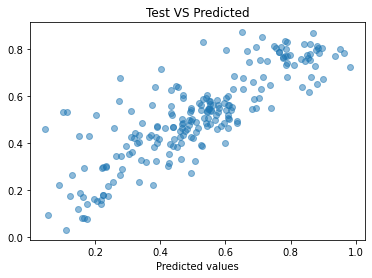

In [318]:
a=["temp", "ftemp", "hum", "windspeed", "cnt"]
temp=dftest.copy(deep=True)
temp[a]=scaler.transform(temp[a])
ytest=temp.pop("cnt")
xtest=temp
a=xtrain_new.columns
xtest=xtest[a]
xtest_lr4=sm.add_constant(xtest)
ypred=lr4.predict(xtest_lr4)
fig=plt.figure()
plt.scatter(ytest, ypred, alpha=0.5)
plt.title("Test VS Predicted")
plt.xlabel("Test values")
plt.xlabel("Predicted values")
plt.show()
scores.append(r2_score(ytest, ypred))

<AxesSubplot:ylabel='Density'>

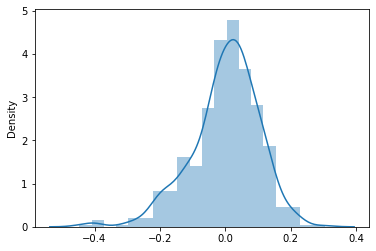

In [319]:
# Error term distribution in our best performing models is normal, which
# means that a linear regression is appropriate
ytrain_pred=lr4.predict(xtrain_lr4)
res=ytrain-ytrain_pred
fig=plt.figure()
sns.distplot(res, bins=20)

In [320]:
scores

[0.7498588502679582,
 0.7498588502679584,
 0.7486090647809922,
 0.7000652279321278]